In [89]:
import numpy as np
from matplotlib import pyplot as plt
import random
import cv2
import tqdm

In [114]:
%matplotlib inline

#### Code from previus asignment

In [54]:
import math
from itertools import product

def gauss(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))
    g /= g.sum()
    return g.reshape((-1, 1)), x

def gaussdx(sigma, size):
    x = np.linspace(-3*sigma-.5, 3*sigma+.5, size)
    g = 1/(sigma*np.sqrt(2*np.pi))*np.exp(-(x**2)/(2*sigma**2))*-2*x/(2*sigma**2)
    g /= np.abs(g).sum()
    return g.reshape((-1, 1)), x

def nonmaxima_suppression_box(img):
    img_suppressed = img.copy()
    for (i, j), pixel_val in np.ndenumerate(img):
        neighbors = product(
            [(i-1)%img.shape[0], i, (i+1)%img.shape[0]], # % img.shape to wrap around image
            [(j-1)%img.shape[1], j, (j+1)%img.shape[1]]
        )
        for u, v in neighbors:
            if pixel_val < img[u, v]:
                img_suppressed[i, j] = 0 # not a maximum, suppress!
    return img_suppressed

def getSize(sigma): 
    return 2*math.ceil(sigma*3)+1

def derive(img, sigma):
    G, _ = gauss(sigma, getSize(sigma))
    D, _ = gaussdx(sigma, getSize(sigma))
    
    img_x = cv2.filter2D(cv2.filter2D(img, -1, -D.T), -1, G)
    img_y = cv2.filter2D(cv2.filter2D(img, -1, G.T), -1, -D)
    img_xx = cv2.filter2D(cv2.filter2D(img_x, -1, -D.T), -1, G)
    img_yy = cv2.filter2D(cv2.filter2D(img_y, -1, G.T), -1, -D)
    img_xy = cv2.filter2D(cv2.filter2D(img_x, -1, G.T), -1, -D)
    
    return img_x, img_y, img_xx, img_yy, img_xy


def hessian_points(img_gray, sigma, threshold):
    _, _, img_xx, img_yy, img_xy = derive(img_gray, sigma)
    
    H_det = (img_xx * img_yy - img_xy ** 2) # * sigma**4
    H_det_s = nonmaxima_suppression_box(H_det)
    points = np.argwhere(H_det_s > threshold)
    return H_det, points

def harris_points(img_gray, sigma, threshold):
    sigma_ = sigma*1.6
    alpha = 0.06
    img_x, img_y, img_xx, img_yy, img_xy = derive(img_gray, sigma)
    G, _ = gauss(sigma_, getSize(sigma_))
    C_11 = cv2.filter2D(cv2.filter2D(img_x**2, -1, G), -1, G.T) * sigma**2
    C_22 = cv2.filter2D(cv2.filter2D(img_y**2, -1, G), -1, G.T) * sigma**2
    C_21 = cv2.filter2D(cv2.filter2D(img_x * img_y, -1, G), -1, G.T) * sigma**2
    
    C_det = (C_11 * C_22 - C_21 ** 2)
    C_tr = C_11 + C_22
    
    r = C_det - alpha * C_tr**2
    points = np.argwhere(nonmaxima_suppression_box(r) > threshold)
    return r, points
    

def simple_descriptors(I, pts, bins=16, radius=40, w=11):

    g, _ = gauss(w, getSize(w))
    d, _ = gaussdx(w, getSize(w))

    Ix = cv2.filter2D(I, cv2.CV_32F, g.T)
    Ix = cv2.filter2D(Ix, cv2.CV_32F, d)

    Iy = cv2.filter2D(I, cv2.CV_32F, g)
    Iy = cv2.filter2D(Iy, cv2.CV_32F, d.T)

    Ixx = cv2.filter2D(Ix, cv2.CV_32F, g.T)
    Ixx = cv2.filter2D(Ixx, cv2.CV_32F, d)

    Iyy = cv2.filter2D(Iy, cv2.CV_32F, g)
    Iyy = cv2.filter2D(Iyy, cv2.CV_32F, d.T)

    mag = np.sqrt(Ix**2+Iy**2)
    mag = np.floor(mag*((bins-1)/np.max(mag)))

    feat = Ixx+Iyy
    feat+=abs(np.min(feat))
    feat = np.floor(feat*((bins-1)/np.max(feat)))

    desc = []

    for x,y in pts:
        minx = max(x-radius, 0)
        maxx = min(x+radius, I.shape[0])
        miny = max(y-radius, 0)
        maxy = min(y+radius, I.shape[1])
        r1 = mag[minx:maxx, miny:maxy].reshape(-1)
        r2 = feat[minx:maxx, miny:maxy].reshape(-1)
    
        a = np.zeros((bins,bins))
        for m, l in zip(r1,r2):
            a[int(m),int(l)]+=1

        a=a.reshape(-1)
        a/=np.sum(a)

        desc.append(a)

    return np.array(desc)

def find_correspondences(descriptors1, descriptors2):
    indices_map = []
    ds = []
    for hist1 in descriptors1:
        d = np.sqrt(np.sum((np.sqrt(hist1) - np.sqrt(descriptors2))**2, axis=1)/2)
        indices_map.append(np.argwhere(d == np.min(d))[0][0])
        ds.append(np.min(d))
        
    return indices_map, ds

def find_matches(img1, img2, sort=False):
    _, list1 = hessian_points(img1, 3, 50)
    _, list2 = hessian_points(img2, 3, 50)
    
    random.shuffle(list2)
    
    descriptors1 = simple_descriptors(img1, list1, bins=32, radius=40, w=11)
    descriptors2 = simple_descriptors(img2, list2, bins=32, radius=40, w=11)
    
    pairs = []
    indices_map1, dist1 = find_correspondences(descriptors1, descriptors2)
    indices_map2, dist2 = find_correspondences(descriptors2, descriptors1)

    for i, j in enumerate(indices_map1):
        if(indices_map2[j] == i):
            pairs.append((i, j, dist1[i]+dist2[j]))
            
    if sort: pairs.sort(key=lambda x: x[2])
    
    return [(i,j) for i, j, _ in pairs], list1, list2

def display_matches(im1, im2, pts1, pts2, matches):

	# NOTE: this will only work correctly for images with the same height
	# NOTE: matches should contain index pairs (i.e. first element is the index to pts1 and second for pts2)

	I = np.hstack((im1,im2))
	w = im1.shape[1]
	
	plt.imshow(I, cmap="gray")

	for i, j in matches:
		p1 = pts1[int(i)]
		p2 = pts2[int(j)]
		plt.plot(p1[1], p1[0], 'bo')
		plt.plot(p2[1]+w, p2[0], 'bo')
		plt.plot([p1[1], p2[1]+w], [p1[0], p2[0]], 'lime')

	plt.draw()
 
def estimate_homography(points_r, points_t):
    A = []
    for (x_r, y_r), (x_t, y_t) in zip(points_r, points_t):
        A.append([x_r, y_r, 1, 0, 0, 0, -x_t * x_r, -x_t * y_r, -x_t])
        A.append([0, 0, 0, x_r, y_r, 1, -y_t * x_r, -y_t * y_r, -y_t])
    A = np.array(A)
    
    U, S, V = np.linalg.svd(A)
    H = V[-1]
    H = H / H[-1]
    return H.reshape((3,3))

# Exercise 1: Disparity

### a) Derive the expression for disparity

$$ \frac{x_1}{f} = \frac{-p_x}{p_z} \qquad \frac{x_2}{f} = \frac{T-p_x}{p_z} $$
$$ x_1 = \frac{p_x}{p_z} f \qquad  x_2 = \frac{p_x-T}{p_z} f $$

$$ d = x_1 - x_2 $$

$$ d = \frac{p_x}{p_z}f - \frac{p_x-T}{p_z}f $$
$$ d = \frac{fT}{p_z} $$

Disperity is inversly proportional with the distance.

### b) Write a script that computes the disparity for a range of values of $p_z$

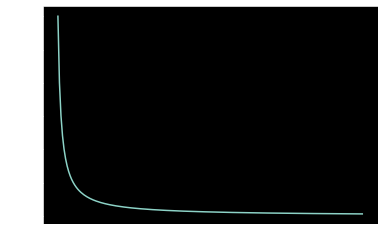

In [18]:
f = 2.5e-3
T = 0.12

z = np.linspace(0.01, 1, 200)
d = f*T/z

plt.plot(d)

### c) Calculate the distance

$$ p_z = \frac{fT}{d} $$


In [24]:
f = 2.5e-3
T = 0.12
px = 7.4e-6
sensor_width = 648*px
for l, r in [(550, 300), (550, 540)]:
    xl = l*px - sensor_width/2
    xr = r*px - sensor_width/2
    disparity = xl - xr

    distance = f*T/disparity

    print(f"disparity: {disparity:.4f}, distance: {distance:.4f}")

disparity: 0.0018, distance: 0.1622
disparity: 0.0001, distance: 4.0541


### d) Write a script that calculates the disparity for an image pair

(<AxesSubplot:>, <matplotlib.image.AxesImage at 0x1f9b096c700>)

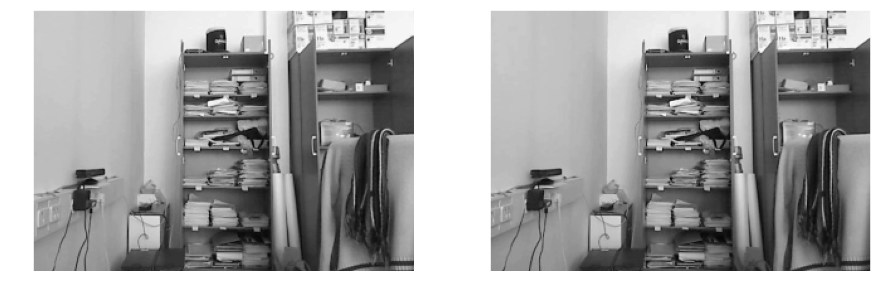

In [81]:
img_left = cv2.cvtColor(cv2.imread('data/disparity/office2_left.png'), cv2.COLOR_BGR2GRAY).astype('float64')
img_right = cv2.cvtColor(cv2.imread('data/disparity/office2_right.png'), cv2.COLOR_BGR2GRAY).astype('float64')

img_left_small = cv2.resize(img_left, dsize=(img_left.shape[1]//2, img_left.shape[0]//2)) 
img_right_small = cv2.resize(img_right, dsize=(img_right.shape[1]//2, img_right.shape[0]//2)) 

plt.figure(figsize=(15,10))
plt.subplot(1,2,1), plt.imshow(img_left_small, 'gray')
plt.subplot(1,2,2), plt.imshow(img_right_small, 'gray')

In [19]:
def get_patch(I, x, y, s):
    return I[max(0, y-s):min(y+s+1, I.shape[0]), max(0, x-s):min(x+s+1, I.shape[1])]

In [115]:
def simple_median2(I, w):
	result = np.zeros_like(I)
	for (y, x), v in np.ndenumerate(I):
		result[y,x] = np.median(get_patch(I, x, y, w))

	return result

In [36]:
def NCC(X,Y):
    X = X.flatten()
    Y = Y.flatten()
    
    if len(X) != len(Y): return 0
    N = len(X)
    
    return 1/N * np.sum((X-np.mean(X))*(Y-np.mean(Y)))/(np.sqrt(1/N * np.sum((X-np.mean(X))**2))*np.sqrt(1/N * np.sum((Y-np.mean(Y))**2)))

In [96]:
def compute_disparity(I1, I2, size=10, max_disparity=10):
    disparity = np.zeros_like(I1)

    prev_y = -1
    for (y, x), _ in tqdm.tqdm(np.ndenumerate(I1), total=I1.size):
            
        X = get_patch(I1, x, y, size)
        max_ncc = 0
        
        for d in range(-max_disparity, max_disparity+1):
            Y = get_patch(I2, x+d, y, size)
            ncc = NCC(X,Y)
            if ncc > max_ncc:
                max_ncc = ncc
                disparity[y,x] = d
                
    return disparity
        

In [128]:
disparity_left = compute_disparity(img_left_small, img_right_small)

100%|██████████| 63024/63024 [01:22<00:00, 765.17it/s]


In [98]:
disparity_right = compute_disparity(img_right_small, img_left_small)

100%|██████████| 63024/63024 [01:27<00:00, 719.74it/s]


(<AxesSubplot:title={'center':'Disparity right median filter'}>,
 Text(0.5, 1.0, 'Disparity right median filter'))

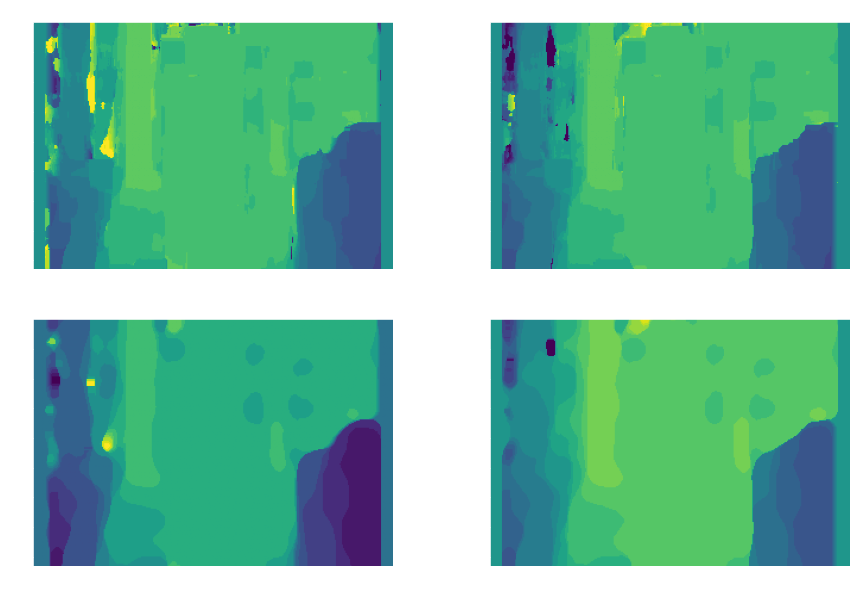

In [118]:
plt.figure(figsize=(15,10))
plt.subplot(2,2,1), plt.imshow(disparity_left), plt.title("Disparity left")
plt.subplot(2,2,2), plt.imshow(-disparity_right), plt.title("Disparity right")

disparity_left_median = simple_median2(disparity_left, 6)
disparity_right_median = simple_median2(disparity_right, 6)

plt.subplot(2,2,3), plt.imshow(disparity_left_median), plt.title("Disparity left median filter")
plt.subplot(2,2,4), plt.imshow(-disparity_right_median), plt.title("Disparity right median filter")


In [121]:
disparity_merged = np.zeros_like(disparity_left_median)
for (y, x), v in np.ndenumerate(disparity_left_median):
    disparity_merged[y,x] = v - disparity_right_median[y, round(x + v)]

(<matplotlib.image.AxesImage at 0x1f9b61569a0>,
 <matplotlib.colorbar.Colorbar at 0x1f9b6137130>)

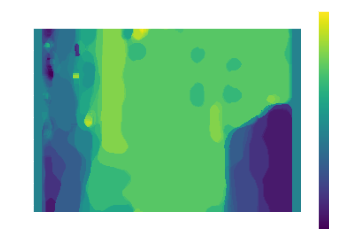

In [124]:
plt.imshow(disparity_merged), plt.colorbar()

# Exercise 2: Fundamental matrix, epipoles, epipolar lines

In [177]:
F = np.array([0, 0, 0.002, 0, 0, -0.012, -0.001, 0.011, -0.085]).reshape((3,3))

x1 = np.array([300, 120, 1])
x2 = np.array([300, 170, 1])


for x in [x1, x2]:
    l = F.dot(x)
    print(f" {l[0]:.3f} x + {l[1]:.3f} y + {l[2]:.3f} = 0")


 0.002 x + -0.012 y + 0.935 = 0
 0.002 x + -0.012 y + 1.485 = 0


> The lines are parallel. The name of the point of intersection is epipole.

## Estimating a fundamental matrix

### a) Implement a function `fundamental_matrix`

In [120]:
def normalize_points(P):
    # P must be a Nx2 vector of points
    # first coordinate is x, second is y

    # returns: normalized points in homogeneous coordinates and 3x3 transformation matrix

    mu = np.mean(P, axis=0) # mean
    scale = np.sqrt(2) / np.mean(np.sqrt(np.sum((P-mu)**2,axis=1))) # scale
    T = np.array([[scale, 0, -mu[0]*scale],[0, scale, -mu[1]*scale],[0,0,1]]) # transformation matrix
    P = np.hstack((P,np.ones((P.shape[0],1)))) # homogeneous coordinates
    res = np.dot(T,P.T).T
    return res, T

In [282]:
def fundamental_matrix(p1, p2):
    p1, T1 = normalize_points(p1)
    p2, T2 = normalize_points(p2)
    up = p1[:,0]
    vp = p1[:,1]
    u = p2[:,0]
    v = p2[:,1]
    A = np.stack([u*up, u*vp, u, v*up, v*vp, v, up, vp, np.ones_like(u)]).T
    U, S, VT = np.linalg.svd(A)
    
    Ft = VT.T[:,-1].reshape((3,3))
    
    U, S, VT = np.linalg.svd(Ft)
    S[-1] = 0
    F = (U * S) @ VT
    
    F = T2.T @ F @ T1
    
    return F

### b) Test your function for fundamental matrix

In [279]:
f = open("data/epipolar/house_points.txt", "r")
points = np.array(f.read().split()).reshape((-1,4)).astype('float')
p1 = points[:,0:2]
p2 = points[:,2:4]

F = fundamental_matrix(p1, p2)
F

array([[-8.85211824e-07, -5.61591880e-06,  1.94310952e-03],
       [ 9.39281870e-06,  6.16883199e-07, -1.20066302e-02],
       [-1.20308414e-03,  1.10370070e-02, -8.53173359e-02]])

In [182]:
def draw_epiline(l,h,w):
    # l: line equation (vector of size 3)
    # h: image height
    # w: image width

    x0, y0 = map(int, [0, -l[2]/l[1]])
    x1, y1 = map(int, [w-1, -(l[2]+l[0]*w)/l[1]])

    plt.plot([x0,x1],[y0,y1],'r')

    plt.ylim([0,h])
    plt.gca().invert_yaxis()

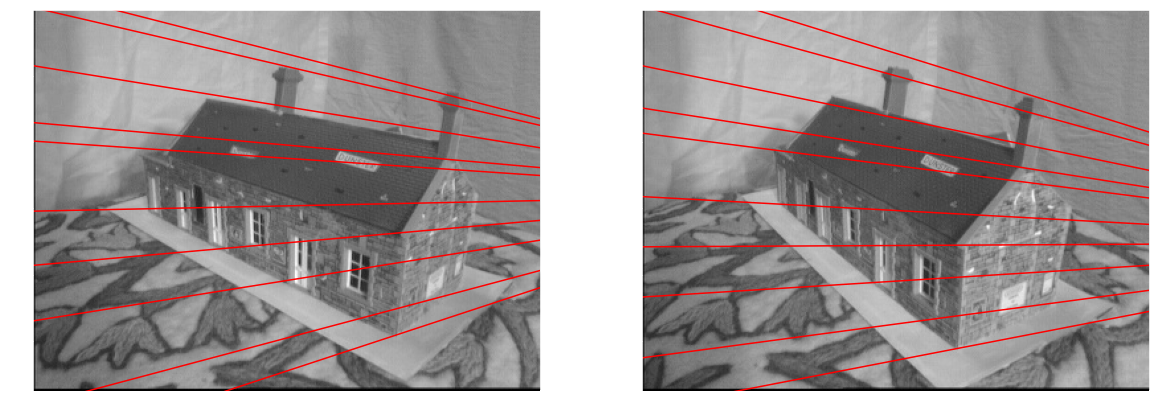

In [302]:
plt.figure(figsize=(20, 10))
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
plt.subplot(1, 2, 1)
plt.imshow(house1, cmap="gray")
for p in p2:
    ph = np.array([p[0], p[1], 1])
    l = F.T @ ph
    draw_epiline(l, house1.shape[0], house1.shape[1])

plt.subplot(1, 2, 2)
plt.imshow(house2, cmap="gray")
for p in p1:
    ph = np.array([p[0], p[1], 1])
    l = F @ ph
    draw_epiline(l, house2.shape[0], house2.shape[1])
 

### c) reprojection error

In [270]:
def reprojection_error(x1, x2, F):
    ph1 = np.array([x1[0], x1[1], 1])
    ph2 = np.array([x2[0], x2[1], 1])
    l1 = F.T @ ph2
    l2 = F @ ph1
    d1 = np.abs(l1[0]*x1[0] + l1[1]*x1[1] + l1[2]) / np.sqrt(l1[0]**2 + l1[1]**2)
    d2 = np.abs(l2[0]*x2[0] + l2[1]*x2[1] + l2[2]) / np.sqrt(l2[0]**2 + l2[1]**2)
    
    d = (d1 + d2) / 2
    
    return d
    

In [283]:
reprojection_error(np.array([85, 233]), np.array([67, 219]), F)

0.14674365570460096

In [284]:
N = 0
e_sum = 0
for x1, x2 in zip(p1, p2):
    e = reprojection_error(x1, x2, F)
    e_sum += e
    # print(e)
    N += 1
    
print(e_sum/N)

0.33091336980543085


### d) Implement the function `get_inliers`

In [285]:
def get_inliers(F, correspondences, epsilon):
    correspondences_filtered = []
    for c in correspondences:
        if reprojection_error(c[0:2], c[2:4], F) < epsilon:
            correspondences_filtered.append(c)
    return np.array(correspondences_filtered)

### e) Implement the function `ransac_fundamental`

In [299]:
def ransac_fundamental(correspondences, k, epsilon):
	best_F = 0
	best_correspondences = []
	for _ in range(k):
		points = correspondences[random.sample(range(len(correspondences)), 8)]
		p1 = points[:,0:2]
		p2 = points[:,2:4]
		F = fundamental_matrix(p1, p2)
		inliers = get_inliers(F, correspondences, epsilon)
		if len(inliers) >= len(best_correspondences):
			best_correspondences = inliers
			inl1 = inliers[:,0:2]
			inl2 = inliers[:,2:4]
			best_F = fundamental_matrix(inl1, inl2)
   
	return best_F, best_correspondences

In [360]:

f = open("data/epipolar/house_matches.txt", "r")
correspondences = np.array(f.read().split()).reshape((-1,4)).astype('float')
correspondences1 = correspondences[:, 0:2]
correspondences2 = correspondences[:, 2:4]

F, inliers = ransac_fundamental(correspondences, 100, 2)

inliers1 = inliers[:,0:2]
inliers2 = inliers[:,2:4]

i = random.randrange(len(inliers))
random_inlier1 = inliers1[i]
random_inlier2 = inliers2[i]

inliers_ratio = len(inliers) / len(correspondences)
random_reprojection_error = reprojection_error(random_inlier1, random_inlier2, F)

F

array([[ 2.09714796e-06,  2.30788439e-05, -4.47590990e-03],
       [-2.74699852e-05,  2.59993496e-06,  1.61605314e-02],
       [ 3.47653392e-03, -1.55357062e-02,  7.28095811e-02]])

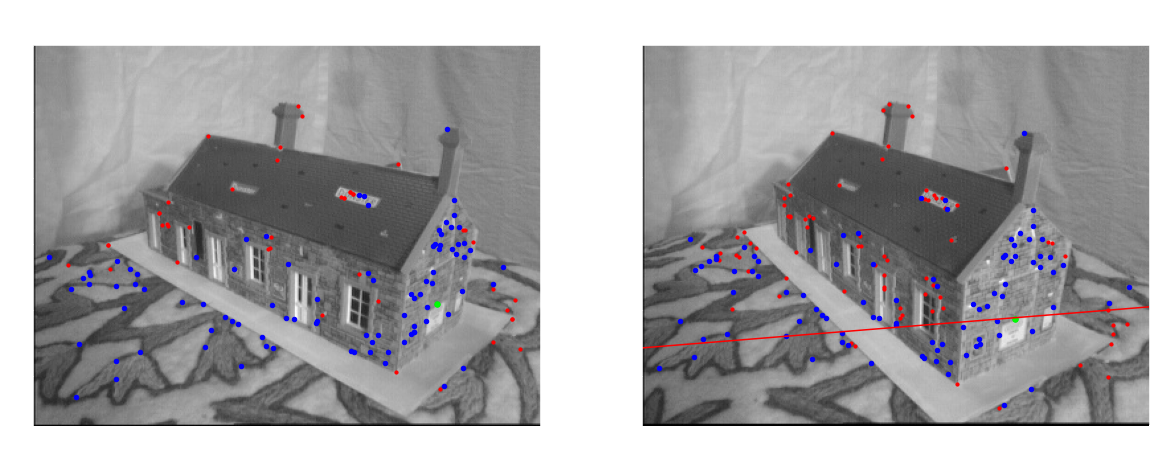

In [361]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(f"Outliers (red), Inliers (blue), Selected (green) \n Inliers: {inliers_ratio*100:3.0f}%, Error: {random_reprojection_error:.3f}")
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
plt.subplots_adjust(top=1.2)
plt.subplot(1, 2, 1)
plt.imshow(house1, cmap="gray")
plt.scatter(correspondences1[:,0], correspondences1[:,1], c='r', s=10)
plt.scatter(inliers1[:,0], inliers1[:,1], c='b', s=20)
plt.scatter([random_inlier1[0]], [random_inlier1[1]], c='lime', s=30)

plt.subplot(1, 2, 2)
plt.imshow(house2, cmap="gray")
plt.scatter(correspondences2[:,0], correspondences2[:,1], c='r', s=10)
plt.scatter(inliers2[:,0], inliers2[:,1], c='b', s=20)
plt.scatter([random_inlier2[0]], [random_inlier2[1]], c='lime', s=30)

ph = np.array([random_inlier1[0], random_inlier1[1], 1])
l = F @ ph
draw_epiline(l, house2.shape[0], house2.shape[1])


### f) Perform fully automatic fundamental matrix estimation

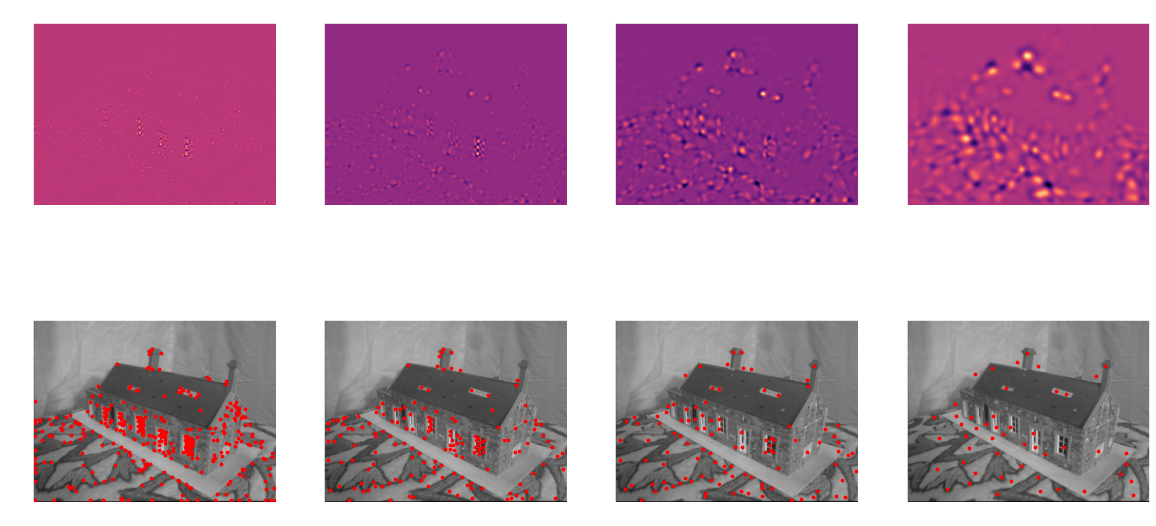

In [366]:
test_points = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2RGB)
test_points_gray = cv2.cvtColor(test_points, cv2.COLOR_RGB2GRAY).astype('float64')

plt.figure(figsize=(20,10))
sigmas = [1, 2, 3, 5]
for i, sigma in enumerate(sigmas):
    plt.subplot(2, len(sigmas), i+1)
    H_det, points = hessian_points(test_points_gray, sigma, 50)
    plt.title(f"Hessian $\sigma = {sigma}$")
    plt.imshow(H_det, cmap="magma")
    plt.subplot(2, len(sigmas), len(sigmas)+i+1)
    plt.imshow(test_points)
    plt.scatter(points[:,1], points[:,0], s=8, c='r')

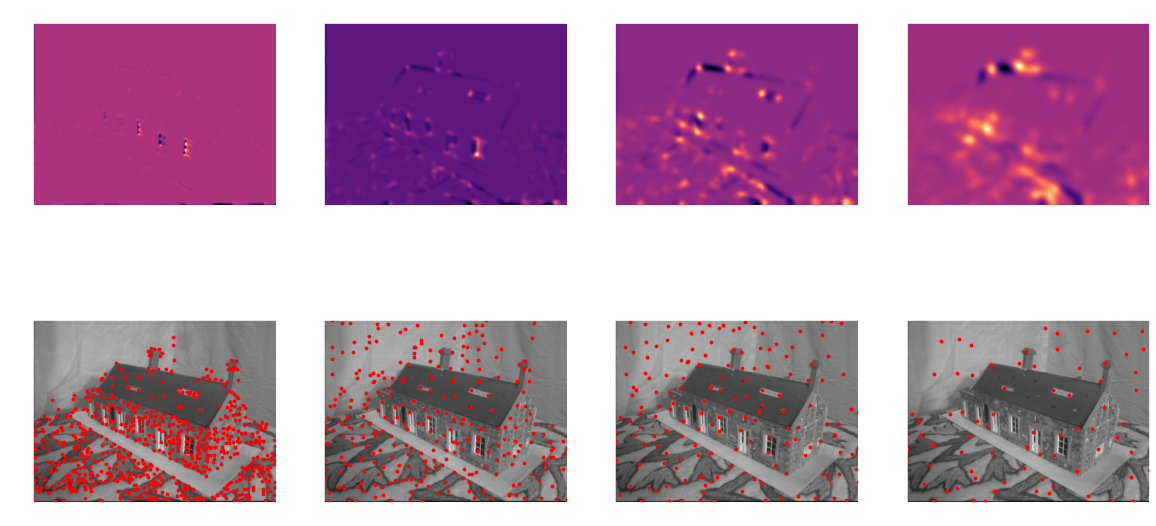

In [373]:
test_points = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2RGB)
test_points_gray = cv2.cvtColor(test_points, cv2.COLOR_RGB2GRAY).astype('float64')

plt.figure(figsize=(20,10))
sigmas = [1, 2, 3, 5]
for i, sigma in enumerate(sigmas):
    plt.subplot(2, len(sigmas), i+1)
    H_det, points = harris_points(test_points_gray, sigma, 50)
    plt.title(f"Harris $\sigma = {sigma}$")
    plt.imshow(H_det, cmap="magma")
    plt.subplot(2, len(sigmas), len(sigmas)+i+1)
    plt.imshow(test_points)
    plt.scatter(points[:,1], points[:,0], s=8, c='r')

#### Find matches

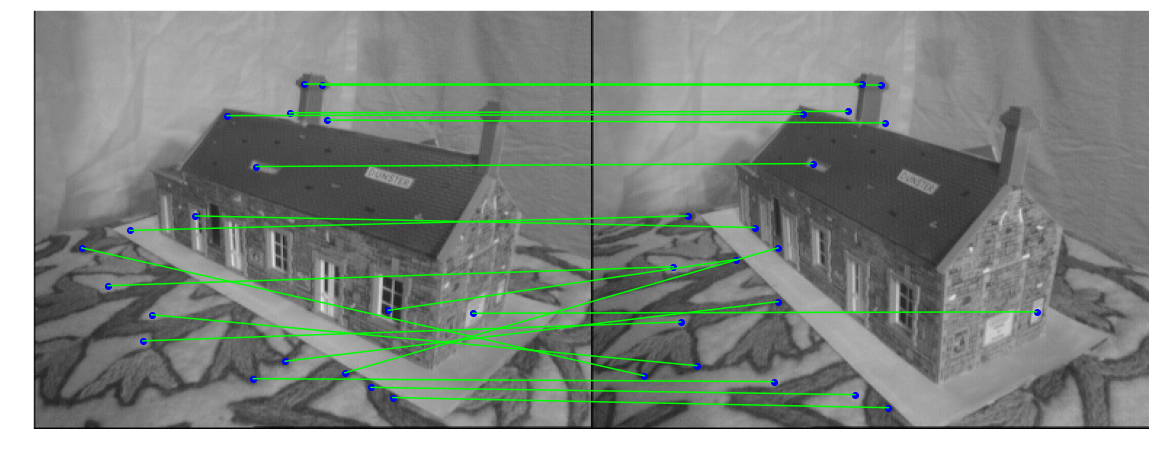

In [377]:
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2RGB)
house1_gray = cv2.cvtColor(house1, cv2.COLOR_RGB2GRAY).astype('float64')
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2RGB)
house2_gray = cv2.cvtColor(house2, cv2.COLOR_RGB2GRAY).astype('float64')

pairs, list1, list2 = find_matches(house1_gray, house2_gray, sort=True)

plt.figure(figsize=(20, 10))
display_matches(house1, house2, list1, list2, pairs[:100])

In [394]:

correspondences = np.array([(*reversed(list1[p[0]]), *reversed(list2[p[1]])) for p in pairs])
correspondences1 = correspondences[:, 0:2]
correspondences2 = correspondences[:, 2:4]

F, inliers = ransac_fundamental(correspondences, 100, 2)

inliers1 = inliers[:,0:2]
inliers2 = inliers[:,2:4]

i = random.randrange(len(inliers))
random_inlier1 = inliers1[i]
random_inlier2 = inliers2[i]

inliers_ratio = len(inliers) / len(correspondences)
random_reprojection_error = reprojection_error(random_inlier1, random_inlier2, F)

F

array([[-3.27919482e-06, -4.48248523e-05, -3.00823812e-03],
       [ 3.38933703e-05, -7.24361214e-06, -4.51521907e-04],
       [ 3.91074974e-03,  1.47483630e-03,  1.02800448e-01]])

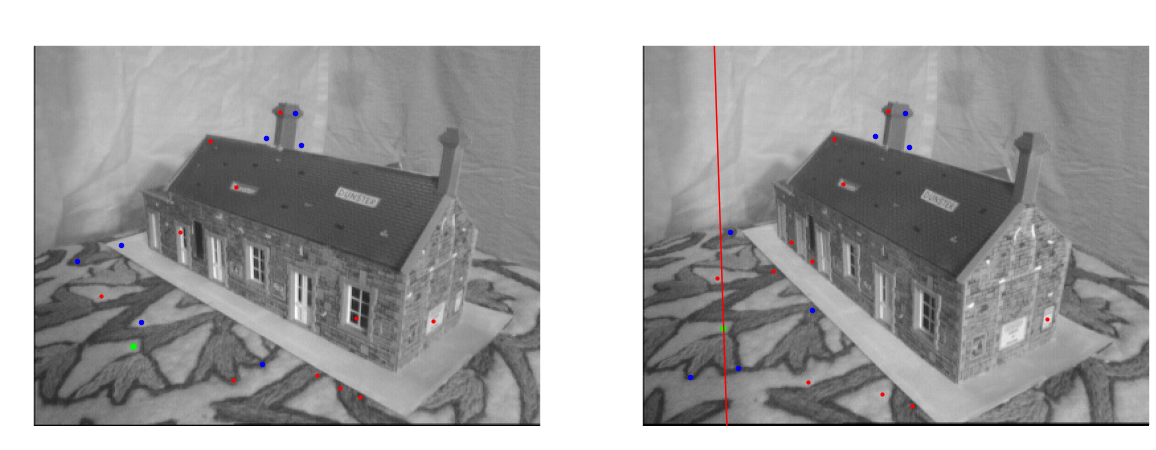

In [395]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle(f"Outliers (red), Inliers (blue), Selected (green) \n Inliers: {inliers_ratio*100:3.0f}%, Error: {random_reprojection_error:.3f}")
house1 = cv2.cvtColor(cv2.imread('data/epipolar/house1.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
house2 = cv2.cvtColor(cv2.imread('data/epipolar/house2.jpg'), cv2.COLOR_BGR2GRAY).astype('float64')
plt.subplots_adjust(top=1.2)
plt.subplot(1, 2, 1)
plt.imshow(house1, cmap="gray")
plt.scatter(correspondences1[:,0], correspondences1[:,1], c='r', s=10)
plt.scatter(inliers1[:,0], inliers1[:,1], c='b', s=20)
plt.scatter([random_inlier1[0]], [random_inlier1[1]], c='lime', s=30)

plt.subplot(1, 2, 2)
plt.imshow(house2, cmap="gray")
plt.scatter(correspondences2[:,0], correspondences2[:,1], c='r', s=10)
plt.scatter(inliers2[:,0], inliers2[:,1], c='b', s=20)
plt.scatter([random_inlier2[0]], [random_inlier2[1]], c='lime', s=30)

ph = np.array([random_inlier1[0], random_inlier1[1], 1])
l = F @ ph
draw_epiline(l, house2.shape[0], house2.shape[1])


# Exercise 3: Triangulation

In [444]:
def triangulate(correspondences, P1, P2):
    points3d = []
    
    for p1x, p1y, p2x, p2y in correspondences:
        p1s = np.array([[0, -1, p1y], [1, 0, -p1x], [-p1y, p1x, 0]])
        p2s = np.array([[0, -1, p2y], [1, 0, -p2x], [-p2y, p2x, 0]])
        
        A1 = p1s @ P1
        A2 = p2s @ P2
        
        A = [A1[0], A1[1], A2[0], A2[1]]
        
        _, _, VT = np.linalg.svd(A)
        
        X = VT[-1]
        
        X /= X[-1]
        
        points3d.append(X[:3])
    return points3d

In [397]:
f = open("data/epipolar/house1_camera.txt", "r")
C1 = np.array(f.read().split()).reshape((3,4)).astype('float')
f = open("data/epipolar/house2_camera.txt", "r")
C2 = np.array(f.read().split()).reshape((3,4)).astype('float')

In [400]:
f = open("data/epipolar/house_points.txt", "r")
points = np.array(f.read().split()).reshape((-1,4)).astype('float')
p1 = points[:,0:2]
p2 = points[:,2:4]

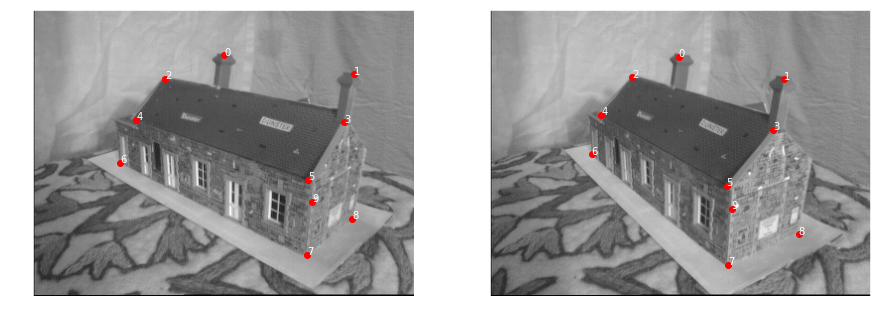

In [422]:
plt.figure(figsize=(15, 10))
plt.subplot(1,2,1)
plt.imshow(house1, cmap="gray")
plt.scatter(p1[:,0], p1[:,1], c='r')
for i, (x, y) in enumerate(p1):
    plt.text(x, y, i)
    
plt.subplot(1,2,2)
plt.imshow(house2, cmap="gray")
plt.scatter(p2[:,0], p2[:,1], c='r')
for i, (x, y) in enumerate(p2):
    plt.text(x, y, i)

In [446]:
points3d = triangulate(points, C1, C2)
T = np.array([[-1,0,0],[0,0,1],[0,-1,0]])
points3d = np.dot(points3d, T)

In [452]:
%matplotlib inline

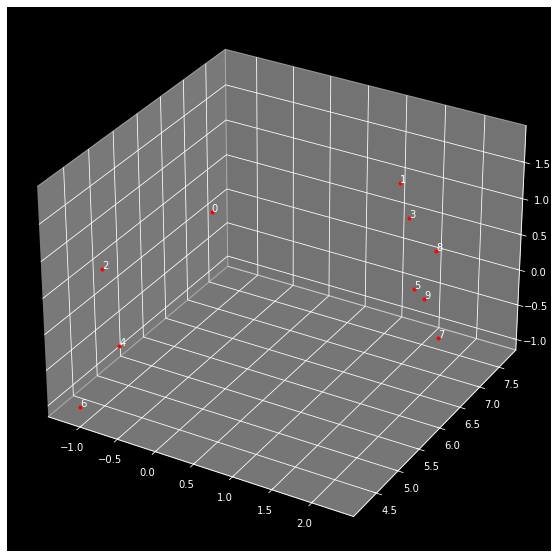

In [453]:
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')

for i, (x,y,z) in enumerate(points3d):
    ax.plot([x],[y],[z], 'r.')
    ax.text(x, y, z, str(i))